In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay,
    PrecisionRecallDisplay, precision_recall_curve,
    make_scorer, average_precision_score,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Input
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC
from keras_tuner import HyperModel, RandomSearch, Objective
from scikeras.wrappers import KerasClassifier



from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

from itertools import product
# from skimpy import skim


In [2]:
df_train = pd.read_csv("../data/ptrain.csv")

In [3]:
df_test = pd.read_csv("../data/ptest.csv")

# Converting categorical data to numeric features + scaling

In [4]:
columns_to_encode = ['home_ownership','verification_status','purpose','application_type','sub_grade']

In [5]:
# One-hot encoding 
df_train = pd.get_dummies(df_train, columns=columns_to_encode)
df_test = pd.get_dummies(df_test, columns=columns_to_encode)

In [6]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  

# Apply binary encoding to the target variable in the training DataFrame
df_train['Label'] = df_train[target_column].map(class_mapping)
df_test['Label'] = df_test[target_column].map(class_mapping)

In [7]:
print(df_train.shape)
print(df_train['Label'].value_counts(normalize=True) * 100)
print(df_test.shape)
print(df_test['Label'].value_counts(normalize=True) * 100)

(223591, 73)
Label
0    80.224159
1    19.775841
Name: proportion, dtype: float64
(112456, 74)
Label
0    80.279398
1    19.720602
Name: proportion, dtype: float64


In [8]:
df_train['purpose_educational'] = False


In [9]:
train_columns = df_train.columns
test_columns = df_test.columns

if set(train_columns) == set(test_columns):
    print("All columns match.")
else:
    print("Columns do not match.")


All columns match.


In [10]:
X_train = df_train.drop(['Label','loan_status'], axis=1)
y_train = df_train['Label']
X_test = df_test.drop(['Label','loan_status'], axis=1)
y_test = df_test['Label']
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [11]:
scaler = RobustScaler()
X_train_robust = scaler.fit_transform(X_train)
X_test_robust = scaler.transform(X_test)

scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

In [12]:
def evaluate_nn(true, pred_probs, train=True):
    # For binary classification problems, threshold probabilities at 0.5 to get class predictions
    pred_class = (pred_probs > 0.5).astype(int)

    auprc_base = average_precision_score(true, pred_probs)

    if train:
        print("Train Result:\n================================================")
    else:
        print("Test Result:\n================================================")

    acc = accuracy_score(true, pred_class) * 100
    clf_report = pd.DataFrame(classification_report(true, pred_class, output_dict=True))
    cm = confusion_matrix(true, pred_class)

    print(f"Accuracy Score: {acc:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {cm}\n")
    print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")


In [13]:
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

# Artificial Network Network (ANN) Models

## Base Models

In [14]:
model = Sequential()

model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=[AUC(name='AUC')])

### robust_basic

In [15]:
r_robust = model.fit(x=X_train_robust, y=y_train, epochs=20,verbose = 2,batch_size=32, validation_data=(X_test_robust, y_test))

Epoch 1/20
6988/6988 - 7s - 1ms/step - AUC: 0.7885 - loss: 0.3800 - val_AUC: 0.8035 - val_loss: 0.3607
Epoch 2/20
6988/6988 - 6s - 880us/step - AUC: 0.8470 - loss: 0.3259 - val_AUC: 0.8823 - val_loss: 0.2848
Epoch 3/20
6988/6988 - 6s - 880us/step - AUC: 0.8810 - loss: 0.2868 - val_AUC: 0.8828 - val_loss: 0.2856
Epoch 4/20
6988/6988 - 6s - 882us/step - AUC: 0.8838 - loss: 0.2830 - val_AUC: 0.8852 - val_loss: 0.2784
Epoch 5/20
6988/6988 - 6s - 871us/step - AUC: 0.8849 - loss: 0.2816 - val_AUC: 0.8861 - val_loss: 0.2789
Epoch 6/20
6988/6988 - 6s - 864us/step - AUC: 0.8864 - loss: 0.2801 - val_AUC: 0.8862 - val_loss: 0.2788
Epoch 7/20
6988/6988 - 6s - 859us/step - AUC: 0.8871 - loss: 0.2806 - val_AUC: 0.8864 - val_loss: 0.2793
Epoch 8/20
6988/6988 - 6s - 859us/step - AUC: 0.8882 - loss: 0.2788 - val_AUC: 0.8865 - val_loss: 0.2787
Epoch 9/20
6988/6988 - 6s - 853us/step - AUC: 0.8890 - loss: 0.2773 - val_AUC: 0.8867 - val_loss: 0.2797
Epoch 10/20
6988/6988 - 6s - 865us/step - AUC: 0.8895 - l

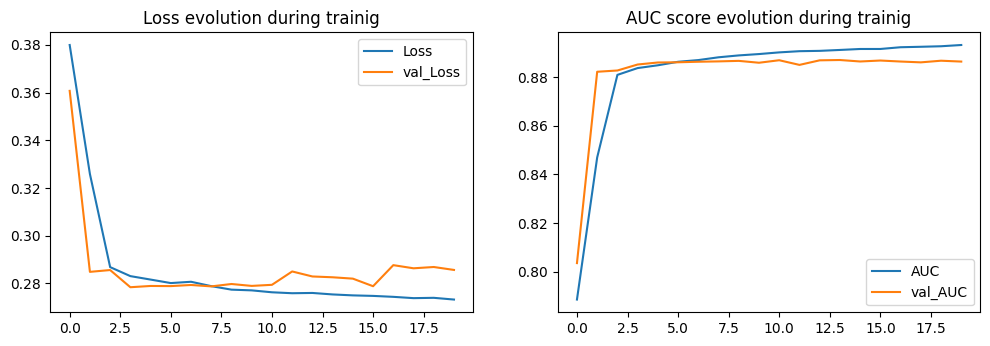

In [16]:
plot_learning_evolution(r_robust)                                                                                 

In [17]:
y_test_pred_robust = model.predict(X_test_robust)
evaluate_nn(y_test, y_test_pred_robust, train=False)

3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 426us/step
Test Result:
Accuracy Score: 88.69%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.879797      0.956539  0.886862       0.918168       0.894931
recall         0.995015      0.446589  0.886862       0.720802       0.886862
f1-score       0.933866      0.608896  0.886862       0.771381       0.869780
support    90279.000000  22177.000000  0.886862  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[89829   450]
 [12273  9904]]

Area Under the Precision-Recall Curve (AUPRC): 0.7581


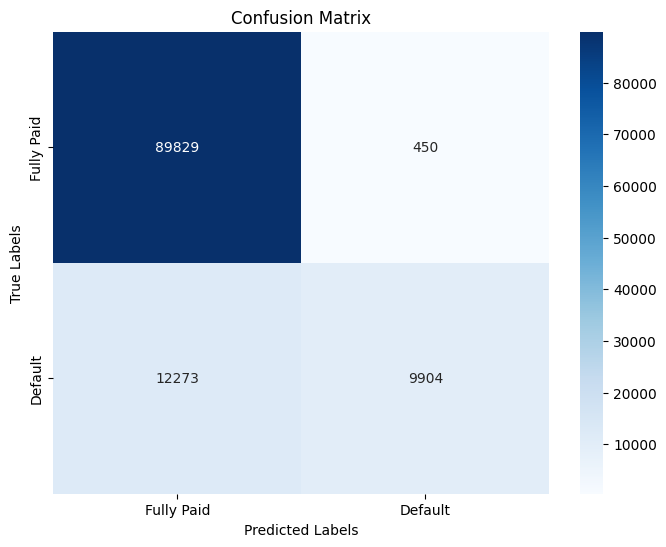

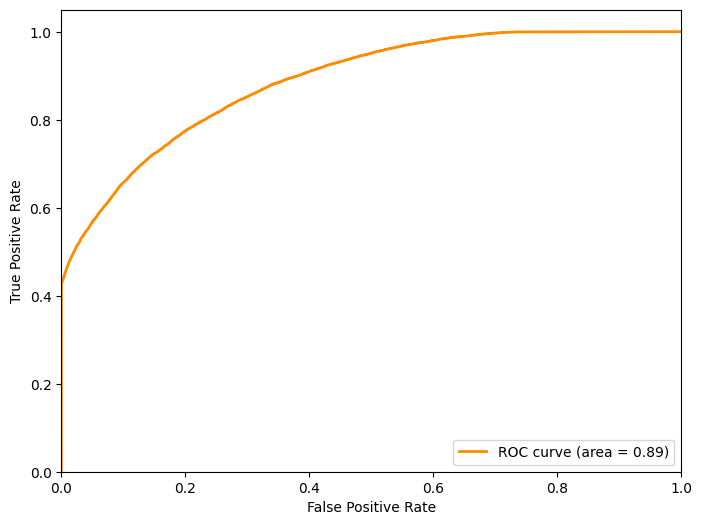

0.5749533642603611


In [18]:
y_pred_op = (y_test_pred_robust > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_robust)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_robust)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

### standard_basic

In [19]:
r_standard = model.fit(x=X_train_standard, y=y_train, epochs=20,verbose = 2,batch_size=32, validation_data=(X_test_standard, y_test))

Epoch 1/20
6988/6988 - 6s - 880us/step - AUC: 0.8182 - loss: 0.4361 - val_AUC: 0.8717 - val_loss: 0.3013
Epoch 2/20
6988/6988 - 6s - 870us/step - AUC: 0.8680 - loss: 0.3085 - val_AUC: 0.8770 - val_loss: 0.2921
Epoch 3/20
6988/6988 - 6s - 859us/step - AUC: 0.8749 - loss: 0.2979 - val_AUC: 0.8787 - val_loss: 0.2910
Epoch 4/20
6988/6988 - 6s - 858us/step - AUC: 0.8789 - loss: 0.2929 - val_AUC: 0.8810 - val_loss: 0.2869
Epoch 5/20
6988/6988 - 6s - 856us/step - AUC: 0.8806 - loss: 0.2897 - val_AUC: 0.8817 - val_loss: 0.2859
Epoch 6/20
6988/6988 - 6s - 854us/step - AUC: 0.8834 - loss: 0.2869 - val_AUC: 0.8841 - val_loss: 0.2832
Epoch 7/20
6988/6988 - 6s - 857us/step - AUC: 0.8848 - loss: 0.2848 - val_AUC: 0.8845 - val_loss: 0.2818
Epoch 8/20
6988/6988 - 6s - 855us/step - AUC: 0.8854 - loss: 0.2839 - val_AUC: 0.8850 - val_loss: 0.2822
Epoch 9/20
6988/6988 - 6s - 853us/step - AUC: 0.8861 - loss: 0.2829 - val_AUC: 0.8841 - val_loss: 0.2834
Epoch 10/20
6988/6988 - 6s - 856us/step - AUC: 0.8864 -

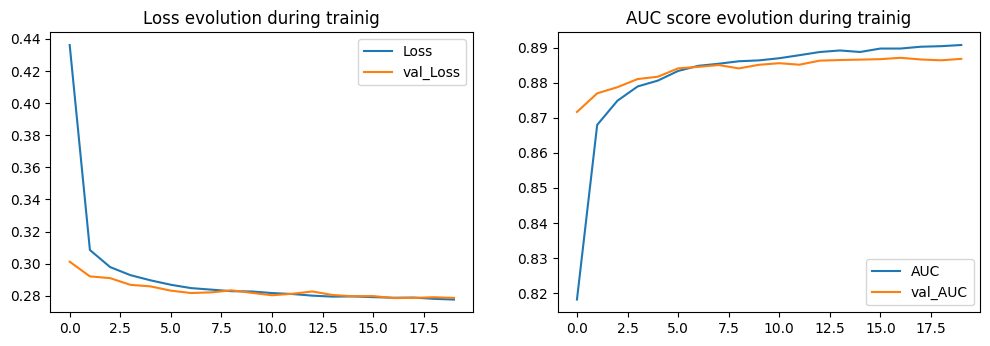

In [20]:
plot_learning_evolution(r_standard)

In [21]:
y_test_pred_standard = model.predict(X_test_standard)
evaluate_nn(y_test, y_test_pred_standard, train=False)

3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step
Test Result:
Accuracy Score: 88.62%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.879984      0.947118  0.886249       0.913551       0.893223
recall         0.993852      0.448212  0.886249       0.721032       0.886249
f1-score       0.933458      0.608472  0.886249       0.770965       0.869369
support    90279.000000  22177.000000  0.886249  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[89724   555]
 [12237  9940]]

Area Under the Precision-Recall Curve (AUPRC): 0.7581


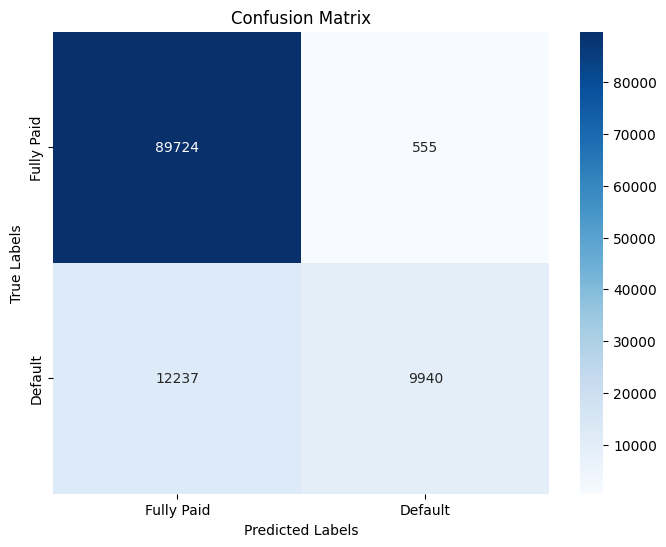

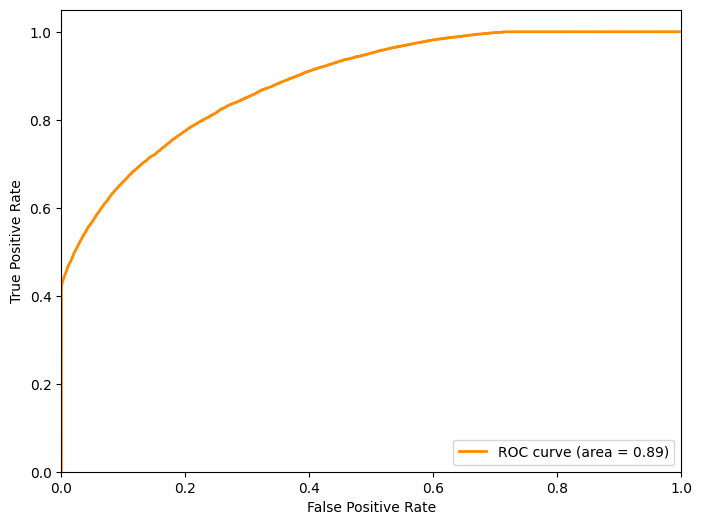

0.5755559817743213


In [22]:
y_pred_op = (y_test_pred_standard > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_standard)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_standard)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

### minmax_basic

In [23]:
r_minmax = model.fit(x=X_train_minmax, y=y_train, epochs=20,verbose = 2,batch_size=32, validation_data=(X_test_minmax, y_test))

Epoch 1/20
6988/6988 - 6s - 867us/step - AUC: 0.7935 - loss: 0.3720 - val_AUC: 0.8341 - val_loss: 0.3410
Epoch 2/20
6988/6988 - 6s - 861us/step - AUC: 0.8475 - loss: 0.3283 - val_AUC: 0.8749 - val_loss: 0.2943
Epoch 3/20
6988/6988 - 6s - 852us/step - AUC: 0.8719 - loss: 0.2989 - val_AUC: 0.8825 - val_loss: 0.2847
Epoch 4/20
6988/6988 - 6s - 858us/step - AUC: 0.8776 - loss: 0.2899 - val_AUC: 0.8842 - val_loss: 0.2817
Epoch 5/20
6988/6988 - 6s - 853us/step - AUC: 0.8807 - loss: 0.2854 - val_AUC: 0.8846 - val_loss: 0.2796
Epoch 6/20
6988/6988 - 6s - 865us/step - AUC: 0.8826 - loss: 0.2828 - val_AUC: 0.8856 - val_loss: 0.2787
Epoch 7/20
6988/6988 - 6s - 859us/step - AUC: 0.8844 - loss: 0.2804 - val_AUC: 0.8854 - val_loss: 0.2790
Epoch 8/20
6988/6988 - 6s - 850us/step - AUC: 0.8845 - loss: 0.2804 - val_AUC: 0.8854 - val_loss: 0.2795
Epoch 9/20
6988/6988 - 6s - 849us/step - AUC: 0.8854 - loss: 0.2793 - val_AUC: 0.8862 - val_loss: 0.2802
Epoch 10/20
6988/6988 - 6s - 845us/step - AUC: 0.8866 -

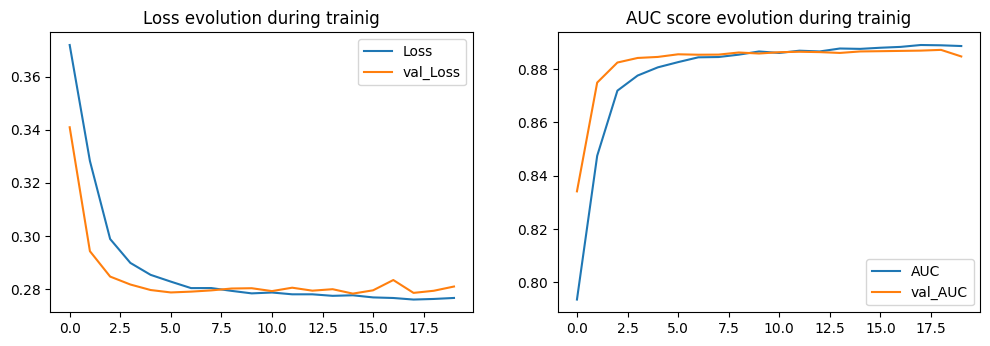

In [24]:
plot_learning_evolution(r_minmax)

In [25]:
y_test_pred_minmax = model.predict(X_test_minmax)
evaluate_nn(y_test, y_test_pred_minmax, train=False)

3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step
Test Result:
Accuracy Score: 88.74%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.878372      0.980398  0.887351       0.929385       0.898493
recall         0.997851      0.437525  0.887351       0.717688       0.887351
f1-score       0.934308      0.605038  0.887351       0.769673       0.869374
support    90279.000000  22177.000000  0.887351  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[90085   194]
 [12474  9703]]

Area Under the Precision-Recall Curve (AUPRC): 0.7581


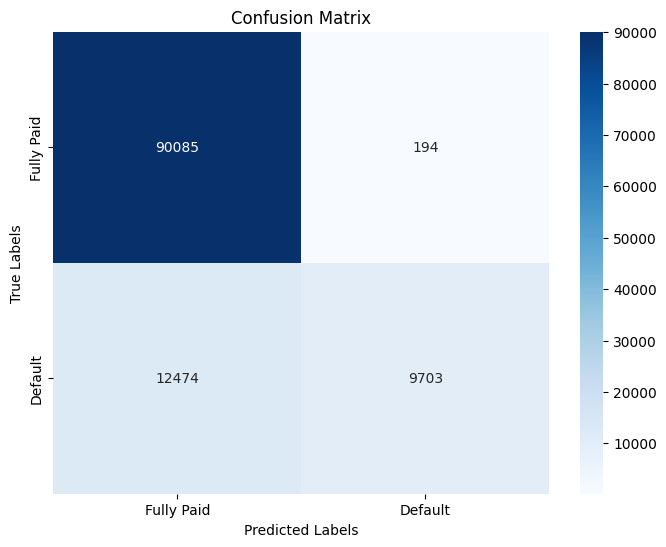

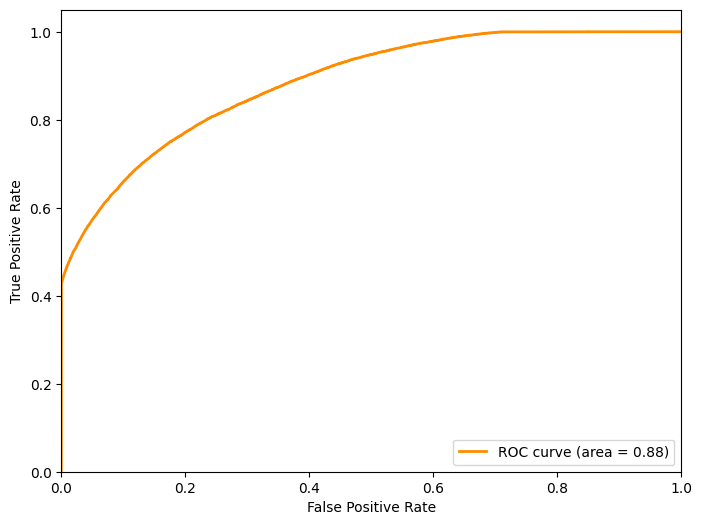

0.574405094209204


In [115]:
y_pred_op = (y_test_pred_minmax > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_minmax)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_minmax)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

### overall PRC curves

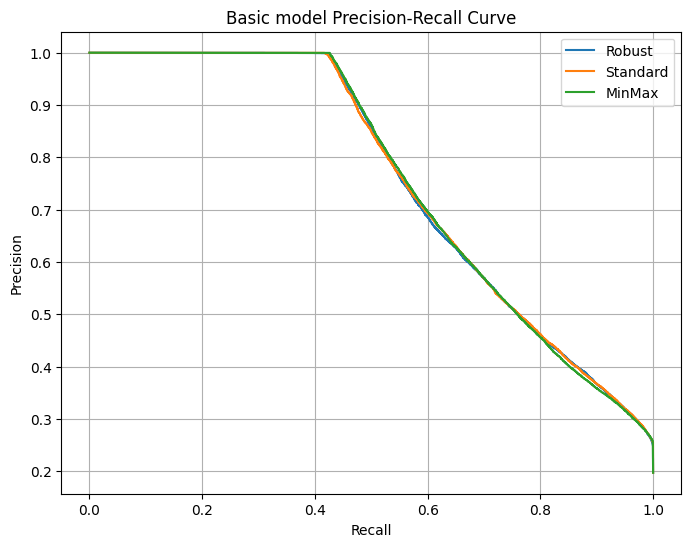

In [27]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_test_pred_robust, y_test_pred_standard, y_test_pred_minmax],[y_test, y_test, y_test], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Basic model Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

## Model Tuning

In [108]:
def create_model_loop(n_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=[AUC(name='AUC')])  # Modify metrics as per your requirement
    return model

In [128]:
def evaluate_nn_op(true, pred_probs, train=True):
    # Predict class labels based on the probability threshold
    pred_class = (pred_probs > 0.5).astype(int)

    # Compute the Area Under the Precision-Recall Curve (AUPRC)
    auprc_base = average_precision_score(true, pred_probs)

    # Calculate accuracy and other classification metrics
    acc = accuracy_score(true, pred_class) * 100
    clf_report = classification_report(true, pred_class, output_dict=True)
    cm = confusion_matrix(true, pred_class)

    # Prepare results with detailed metrics for both classes
    results = {
        "Phase": "Train" if train else "Test",
        "Overall Accuracy": acc,
        "Class 0 Precision": clf_report['0']['precision'],
        "Class 0 Recall": clf_report['0']['recall'],
        "Class 0 F1-Score": clf_report['0']['f1-score'],
        "Class 1 Precision": clf_report['1']['precision'],
        "Class 1 Recall": clf_report['1']['recall'],
        "Class 1 F1-Score": clf_report['1']['f1-score'],
        "Confusion Matrix": cm.tolist(),  # Convert numpy array to list
        "AUPRC": auprc_base
    }

    return results

In [129]:
param_grid = {
    'classifier__n_units': [32, 64, 128, 256],
    'classifier__dropout_rate': [0.1, 0.2, 0.5],
    'classifier__learning_rate': [0.01, 0.001, 0.0001]
}

In [130]:
param_combinations = list(product(param_grid['classifier__n_units'], 
                                  param_grid['classifier__dropout_rate'], 
                                  param_grid['classifier__learning_rate']))

results_list = []

# Assuming param_combinations is a list of tuples, each with (n_units, dropout_rate, learning_rate)
for n_units, dropout_rate, learning_rate in param_combinations:
    # Create and train the model
    model = create_model_loop(n_units=n_units, dropout_rate=dropout_rate, learning_rate=learning_rate)
    model.fit(X_train_minmax, y_train, epochs=10, batch_size=32, verbose=0)

    # Predict probabilities on the test set
    y_test_pred_probs = model.predict(X_test_minmax)[:, 0]  # Ensure correct indexing if model.predict returns a 2D array

    # Evaluate the model on the test data and collect results
    test_results = evaluate_nn_op(y_test, y_test_pred_probs, train=False)
    results_list.append(test_results)

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 398us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 426us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 419us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 436us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 399us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 433us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 422us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 419us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 429us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 419us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 424us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 439us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 433us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 443us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 449us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 444us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 447us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step


In [131]:
results_df = pd.DataFrame(results_list)
results_df.to_csv('model_evaluation_results.csv', index=False)

## ANN Models w/ Undersampling

In [132]:
rus = RandomUnderSampler(random_state=42)

In [133]:
X_under, y_under = rus.fit_resample(X_train_minmax, y_train)

In [134]:
param_combinations = list(product(param_grid['classifier__n_units'], 
                                  param_grid['classifier__dropout_rate'], 
                                  param_grid['classifier__learning_rate']))

results_list_under = []

# Assuming param_combinations is a list of tuples, each with (n_units, dropout_rate, learning_rate)
for n_units, dropout_rate, learning_rate in param_combinations:
    # Create and train the model
    model = create_model_loop(n_units=n_units, dropout_rate=dropout_rate, learning_rate=learning_rate)
    model.fit(X_under, y_under, epochs=10, batch_size=32, verbose=0)

    # Predict probabilities on the test set
    y_test_pred_probs = model.predict(X_test_minmax)[:, 0]  # Ensure correct indexing if model.predict returns a 2D array

    # Evaluate the model on the test data and collect results
    test_results = evaluate_nn_op(y_test, y_test_pred_probs, train=False)
    results_list_under.append(test_results)

c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 428us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 382us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 394us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 1s 409us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 419us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 420us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 428us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 439us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 441us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 427us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 425us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 426us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 437us/step


c:\Users\JYXha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3515/3515 ━━━━━━━━━━━━━━━━━━━━ 2s 434us/step


In [135]:
results_under_df = pd.DataFrame(results_list_under)
results_under_df.to_csv('model_evaluation_results_under.csv', index=False)